##  _Amazon Fine Food Reviews - TSNE Plots_

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [2]:
df= pd.read_csv('../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
print(df.shape)

(568454, 10)


In [4]:
connection = sqlite3.connect('../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/database.sqlite')
filter_data = pd.read_sql_query("""SELECT * from Reviews where Score !=3""",connection)
actual_score =filter_data['Score']
def partition(x):
    if x<3:
        return 'Negative'
    else:
        return 'Positive'
    
pos_or_neg = actual_score.map(partition) 
# or I can use lambda function
#pos_or_neg = actual_score.apply(lambda x:'Positive' if int(x)>3 else 'Negative')
filter_data['Score'] = pos_or_neg
filter_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
print(filter_data.shape)

(525814, 10)


###### Data Cleaning Process

In [5]:
display= pd.read_sql_query("""SELECT *FROM Reviews WHERE Score != 3 AND UserId="AR5J8UI46CURR" ORDER BY ProductID""", connection)
sorted_data = filter_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
drop_data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},inplace=False,keep='first')
drop_data.shape

(364173, 10)

###### Removing the book reviews which got mixed up with the food reviews

In [6]:
drop_data1= drop_data[drop_data['ProductId'].str[0]!='0' ]
drop_data1.shape

(364139, 10)

In [7]:
drop_data1=drop_data1[drop_data1.HelpfulnessNumerator<=drop_data1.HelpfulnessDenominator]
drop_data1.shape

(364137, 10)

In [8]:
drop_data1['Score'].value_counts()

Positive    307029
Negative     57108
Name: Score, dtype: int64

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sriramthotapallim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

###### Text Preprocessing

In [9]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,'',sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [10]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in drop_data1['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(snow.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (drop_data1['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(drop_data1['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1

In [11]:
drop_data1['Cleaned_Text'] = final_string
drop_data1['Cleaned_Text'] = drop_data1['Cleaned_Text'].str.decode("utf-8")

###### Getting the first 2000 Positive reviews in the dataset after data cleaning and preprocessing

In [12]:
pos_1000 = drop_data1.loc[drop_data1['Score']=='Positive']
pos_1000 = pos_1000.head(2000)
pos_1000['Score'].value_counts()

Positive    2000
Name: Score, dtype: int64

###### Getting the first 2000 Negative reviews in the dataset after data cleaning and preprocessing

In [13]:
neg_1000 = drop_data1.loc[drop_data1['Score']=='Negative']
neg_1000 = neg_1000.head(2000)
neg_1000['Score'].value_counts()

Negative    2000
Name: Score, dtype: int64

###### Merging both positive and negative reviews into a single dataframe

In [14]:
pos_neg_1000 = pd.merge(pos_1000,neg_1000,how='outer')
pos_neg_1000['Score'].value_counts()

Negative    2000
Positive    2000
Name: Score, dtype: int64

### Bag of Words Representation

In [15]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(pos_neg_1000['Cleaned_Text'].values)

In [16]:
final_counts = final_counts.astype(float).todense()

In [17]:
final_counts = final_counts[0:4000,:]

###### Data Standardization

In [18]:
from sklearn.preprocessing import StandardScaler
std_data = StandardScaler().fit_transform(final_counts)

In [19]:
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
model = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
#model = TSNE(n_jobs=2)
tsne_data = model.fit_transform(std_data)

In [20]:
final_label = pos_neg_1000['Score'][0:4000,]

In [21]:
final_label.value_counts()

Negative    2000
Positive    2000
Name: Score, dtype: int64

### TSNE Plot of Bag of Words

##### TSNE Plot with Perplexity 50 and No. of Iterations 5000

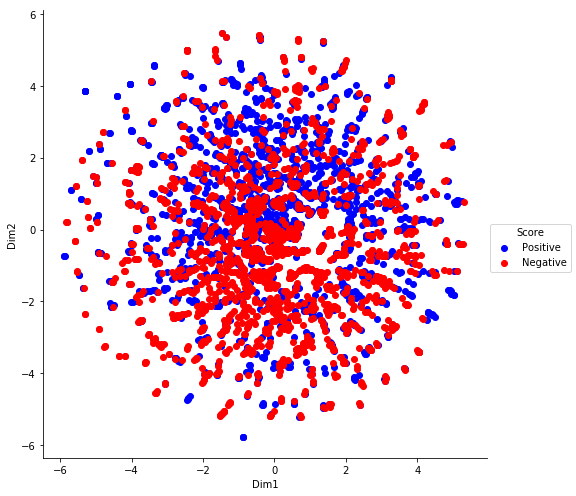

In [22]:
tsne_data = np.vstack((tsne_data.T,final_label)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()
# Positive in Blue and Negative in Red
plt.show()

In [23]:
from MulticoreTSNE import MulticoreTSNE as TSNE
model = TSNE(n_components=2,random_state=0,perplexity=10,n_iter=1000)
#model = TSNE(n_jobs=2)
tsne_data = model.fit_transform(std_data)

##### TSNE Plot with Perplexity 10 and No. of Iterations 1000

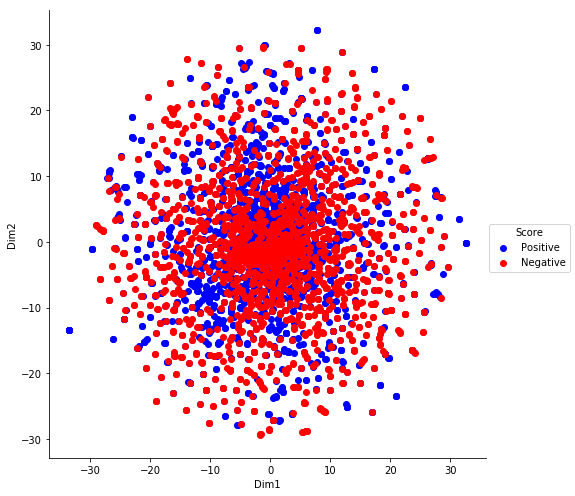

In [24]:
tsne_data = np.vstack((tsne_data.T,final_label)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()
# Positive in Blue and Negative in Red
plt.show()

In [25]:
from MulticoreTSNE import MulticoreTSNE as TSNE
model = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=2000)
#model = TSNE(n_jobs=2)
tsne_data = model.fit_transform(std_data)

##### TSNE Plot with Perplexity 30 and No. of Iterations 2000

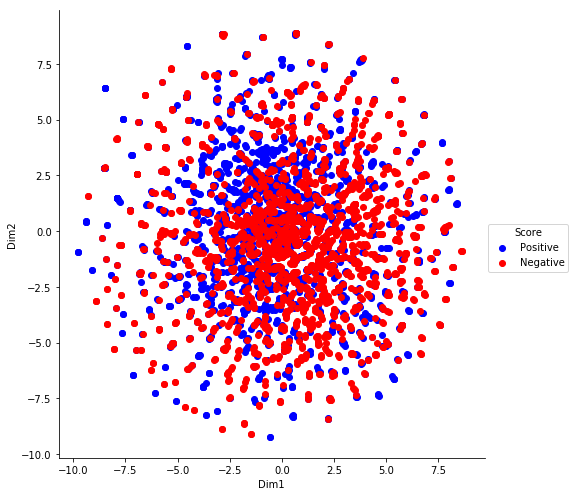

In [26]:
tsne_data = np.vstack((tsne_data.T,final_label)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()
# Positive in Blue and Negative in Red
plt.show()

In [27]:
from MulticoreTSNE import MulticoreTSNE as TSNE
model = TSNE(n_components=2,random_state=0,perplexity=40,n_iter=1000)
#model = TSNE(n_jobs=2)
tsne_data = model.fit_transform(std_data)

##### TSNE Plot with Perplexity 40 and No. of Iterations 1000

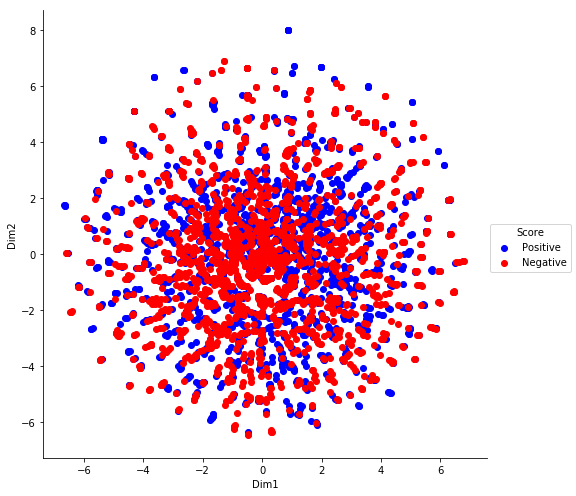

In [28]:
tsne_data = np.vstack((tsne_data.T,final_label)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()
# Positive in Blue and Negative in Red
plt.show()

In [29]:
pos_1000.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,Positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,Positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,Positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...,book easi read ingredi avail store unlik recip...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,Positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,Positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


### ngrams Representation (Trigram)

In [30]:
ngram_vect = CountVectorizer(ngram_range=(1,3))
final_counts_ngram = ngram_vect.fit_transform(pos_neg_1000['Cleaned_Text'].values)

In [31]:
final_counts_ngram = final_counts_ngram.astype(float).todense()

In [32]:
final_counts_ngram = final_counts_ngram[0:4000,:]

###### Data Standardization

In [33]:
from sklearn.preprocessing import StandardScaler
std_data_ngram = StandardScaler().fit_transform(final_counts_ngram)

In [34]:
#from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
#model = TSNE(n_jobs=2)
tsne_data_ngram = model.fit_transform(std_data_ngram)

### TSNE Plot of ngrams(Trigrams)

##### TSNE Plot with Perplexity 50 and No. of Iterations 5000

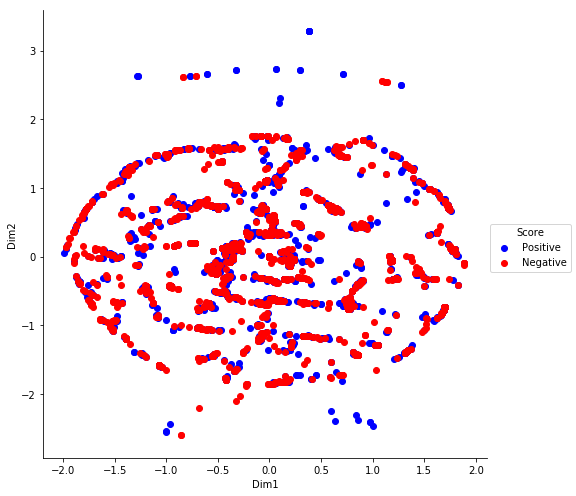

In [35]:
tsne_data_ngram = np.vstack((tsne_data_ngram.T,final_label)).T
tsne_df_ngram = pd.DataFrame(data=tsne_data_ngram,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_ngram,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [36]:
#from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=0,perplexity=10,n_iter=1000)
#model = TSNE(n_jobs=2)
tsne_data_ngram = model.fit_transform(std_data_ngram)

##### TSNE Plot with Perplexity 10 and No. of Iterations 1000

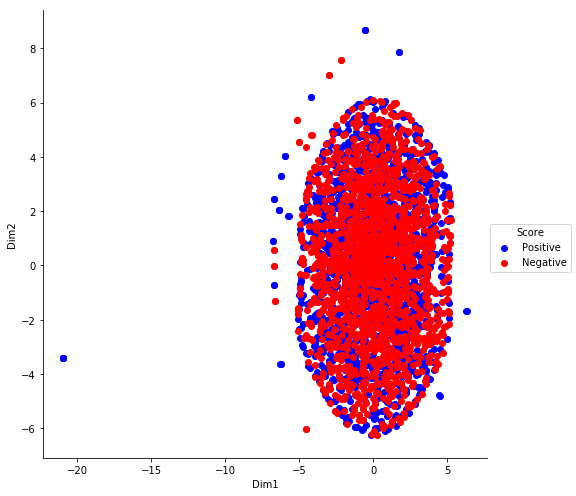

In [37]:
tsne_data_ngram = np.vstack((tsne_data_ngram.T,final_label)).T
tsne_df_ngram = pd.DataFrame(data=tsne_data_ngram,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_ngram,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [38]:
#from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=2000)
#model = TSNE(n_jobs=2)
tsne_data_ngram = model.fit_transform(std_data_ngram)

##### TSNE Plot with Perplexity 30 and No. of Iterations 2000

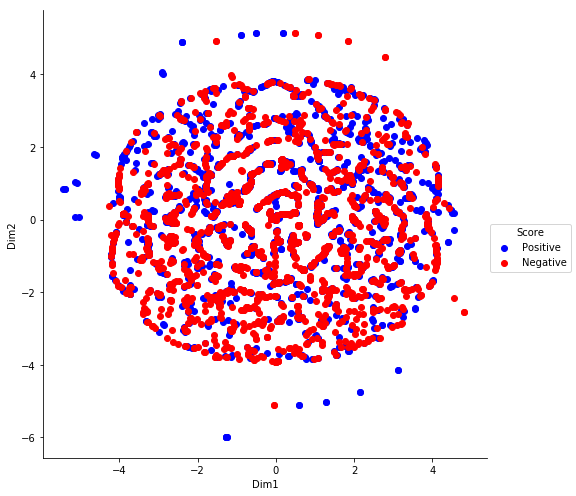

In [39]:
tsne_data_ngram = np.vstack((tsne_data_ngram.T,final_label)).T
tsne_df_ngram = pd.DataFrame(data=tsne_data_ngram,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_ngram,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [41]:
#from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=0,perplexity=40,n_iter=1000)
#model = TSNE(n_jobs=2)
tsne_data_ngram = model.fit_transform(std_data_ngram)

##### TSNE Plot with Perplexity 40 and No. of Iterations 1000

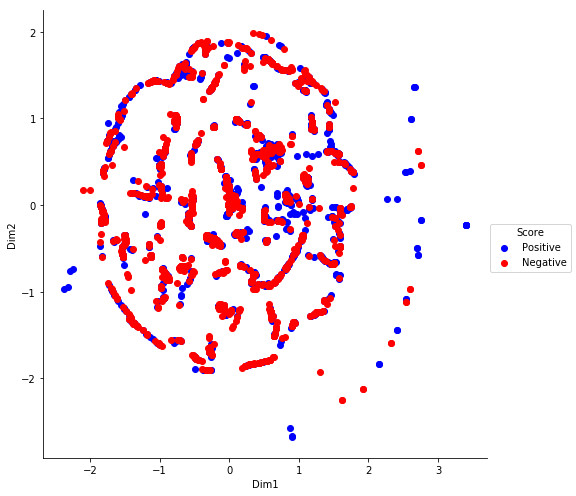

In [42]:
tsne_data_ngram = np.vstack((tsne_data_ngram.T,final_label)).T
tsne_df_ngram = pd.DataFrame(data=tsne_data_ngram,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_ngram,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

### Tf-Idf Representation 

In [55]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(pos_neg_1000['Cleaned_Text'].values)

In [56]:
final_tf_idf = final_tf_idf.astype(float).todense()

In [57]:
final_tf_idf = final_tf_idf[0:4000,:]

###### Data Standardization

In [58]:
from sklearn.preprocessing import StandardScaler
std_data_tf_idf = StandardScaler().fit_transform(final_tf_idf)

In [143]:
#from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
#model = TSNE(n_jobs=2)
tsne_data_tf_idf = model.fit_transform(std_data_tf_idf)

### TSNE Plot of Tf-Idf

##### TSNE Plot with Perplexity 50 and No. of Iterations 5000

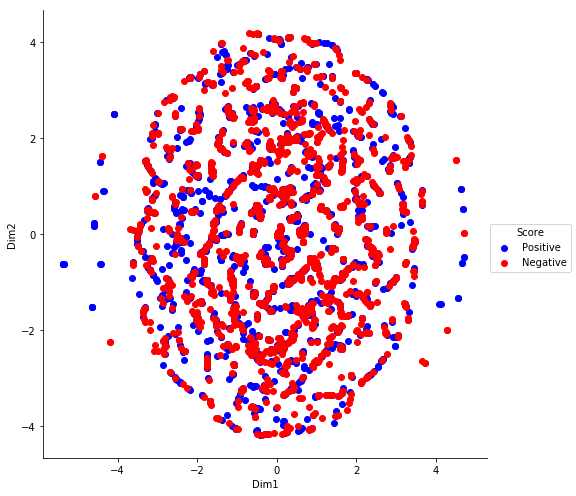

In [144]:
tsne_data_tf_idf = np.vstack((tsne_data_tf_idf.T,final_label)).T
tsne_df_tf_idf = pd.DataFrame(data=tsne_data_tf_idf,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_tf_idf,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [49]:
#from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=0,perplexity=10,n_iter=1000)
#model = TSNE(n_jobs=2)
tsne_data_tf_idf = model.fit_transform(std_data_tf_idf)

##### TSNE Plot with Perplexity 10 and No. of Iterations 1000

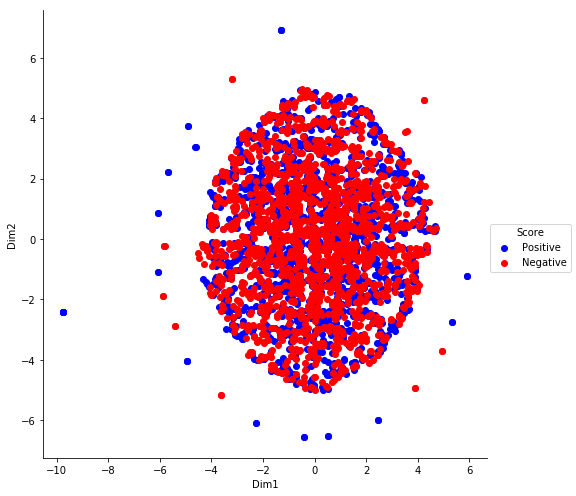

In [50]:
tsne_data_tf_idf = np.vstack((tsne_data_tf_idf.T,final_label)).T
tsne_df_tf_idf = pd.DataFrame(data=tsne_data_tf_idf,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_tf_idf,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [51]:
#from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=2000)
#model = TSNE(n_jobs=2)
tsne_data_tf_idf = model.fit_transform(std_data_tf_idf)

##### TSNE Plot with Perplexity 30 and No. of Iterations 2000

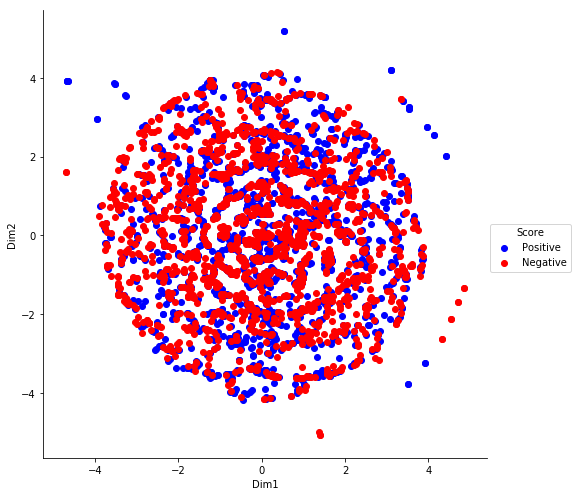

In [52]:
tsne_data_tf_idf = np.vstack((tsne_data_tf_idf.T,final_label)).T
tsne_df_tf_idf = pd.DataFrame(data=tsne_data_tf_idf,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_tf_idf,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [53]:
#from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=0,perplexity=40,n_iter=1000)
#model = TSNE(n_jobs=2)
tsne_data_tf_idf = model.fit_transform(std_data_tf_idf)

##### TSNE Plot with Perplexity 40 and No. of Iterations 1000

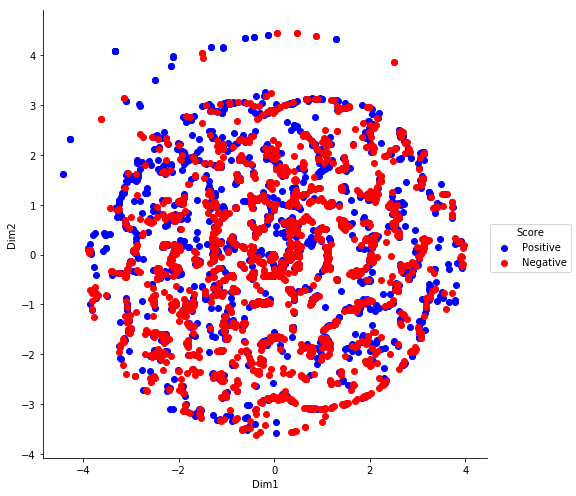

In [54]:
tsne_data_tf_idf = np.vstack((tsne_data_tf_idf.T,final_label)).T
tsne_df_tf_idf = pd.DataFrame(data=tsne_data_tf_idf,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_tf_idf,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

### Average Word2Vec Representation 

In [59]:
list_of_sent = []
for sent in pos_neg_1000['Cleaned_Text'].values:
    list_of_sent.append(sent.split())

In [60]:
w2v_model = Word2Vec(list_of_sent,min_count=5,workers=4,size=50)

In [61]:
# w2v_words = list(w2v_model.wv.vocab)
# print(w2v_words[0:30])
#print(w2v_model.wv.vocab)
#print(w2v_model['mix'])
w2v_words = list(w2v_model.wv.vocab)
print(list_of_sent[0])
print(w2v_words[0:38])
print(w2v_model.wv['product']+w2v_model.wv['archer']+w2v_model.wv['farm'])

['product', 'archer', 'farm', 'best', 'drink', 'mix', 'ever', 'mix', 'flavor', 'packet', 'water', 'bottl', 'contain', 'natur', 'sweetner', 'stevia', 'real', 'fruit', 'flavor', 'food', 'color', 'color', 'fruit', 'veget', 'color', 'pure', 'natur', 'tast', 'great', 'eight', 'packet', 'box', 'contain', 'calori', 'per', 'packet', 'thank', 'archer', 'farm']
['product', 'archer', 'farm', 'best', 'drink', 'mix', 'ever', 'flavor', 'packet', 'water', 'bottl', 'contain', 'natur', 'stevia', 'real', 'fruit', 'food', 'color', 'veget', 'pure', 'tast', 'great', 'eight', 'box', 'calori', 'per', 'thank', 'dog', 'love', 'saw', 'pet', 'store', 'tag', 'attach', 'regard', 'made', 'china', 'satisfi']
[ 0.51556814 -0.86498797 -0.79404026 -0.5951545  -0.6325824  -2.0092218
 -0.8887146  -1.8118854  -0.85758674  0.01759361 -1.3474141   0.96641207
  0.01240475 -1.1636186  -0.5089005  -1.237287    1.3205712  -0.17978859
 -1.0928226  -0.540887   -1.0222019  -0.23471113  0.67430365  0.33078563
  0.40999448 -0.433538

In [62]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
print(sent_vectors[0])

4000
50
[ 0.20888704 -0.34135743 -0.2856559  -0.24261286 -0.23528755 -0.76824341
 -0.43407673 -0.75396213 -0.39266011  0.0266117  -0.51147117  0.37747968
 -0.03811561 -0.56851988 -0.21844848 -0.44555728  0.50051132 -0.01385677
 -0.41867305 -0.16548792 -0.35843148 -0.15958151  0.2704682   0.15408906
  0.15022575 -0.17808291 -0.24899829  0.28698744 -0.03696921 -0.46985781
  0.07276081 -0.03691342 -0.37295424  0.49644614 -0.24191813  0.5953911
 -0.4192066  -0.06551273 -0.23973271  0.30185375 -0.6155658   0.11600942
  0.40004877  0.28209932  0.48167446 -0.14669584  0.14569135 -0.13596461
 -0.14862662  0.44464239]


In [145]:
sent_vectors_arr = np.asarray(sent_vectors)
model = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
#model = TSNE(n_jobs=2)
tsne_data_avg_w2v = model.fit_transform(sent_vectors_arr)

### TSNE Plot of Average Word2Vec

##### TSNE Plot with Perplexity 50 and No. of Iterations 5000

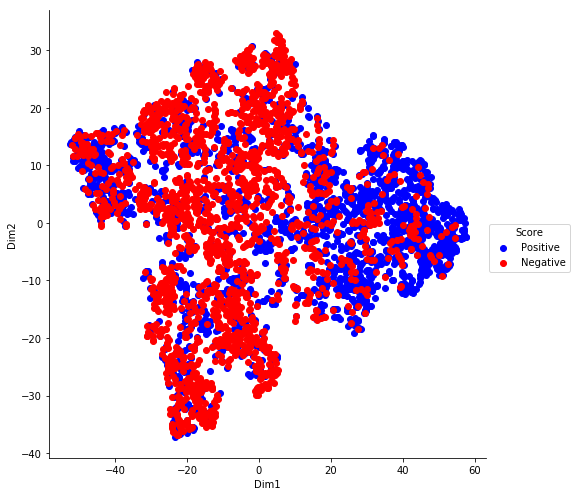

In [146]:
tsne_data_avg_w2v = np.vstack((tsne_data_avg_w2v.T,final_label)).T
tsne_df_avg_w2v = pd.DataFrame(data=tsne_data_avg_w2v,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_avg_w2v,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [63]:
sent_vectors_arr = np.asarray(sent_vectors)
model = TSNE(n_components=2,random_state=0,perplexity=10,n_iter=1000)
#model = TSNE(n_jobs=2)
tsne_data_avg_w2v = model.fit_transform(sent_vectors_arr)

##### TSNE Plot with Perplexity 10 and No. of Iterations 1000

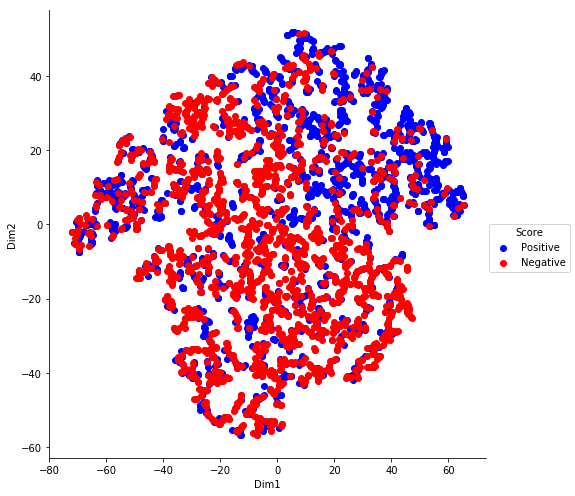

In [64]:
tsne_data_avg_w2v = np.vstack((tsne_data_avg_w2v.T,final_label)).T
tsne_df_avg_w2v = pd.DataFrame(data=tsne_data_avg_w2v,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_avg_w2v,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [65]:
sent_vectors_arr = np.asarray(sent_vectors)
model = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=2000)
#model = TSNE(n_jobs=2)
tsne_data_avg_w2v = model.fit_transform(sent_vectors_arr)

##### TSNE Plot with Perplexity 30 and No. of Iterations 2000

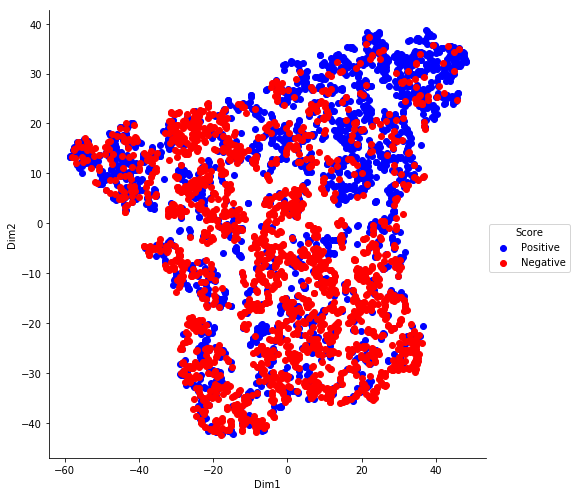

In [66]:
tsne_data_avg_w2v = np.vstack((tsne_data_avg_w2v.T,final_label)).T
tsne_df_avg_w2v = pd.DataFrame(data=tsne_data_avg_w2v,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_avg_w2v,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [67]:
sent_vectors_arr = np.asarray(sent_vectors)
model = TSNE(n_components=2,random_state=0,perplexity=40,n_iter=1000)
#model = TSNE(n_jobs=2)
tsne_data_avg_w2v = model.fit_transform(sent_vectors_arr)

##### TSNE Plot with Perplexity 40 and No. of Iterations 1000

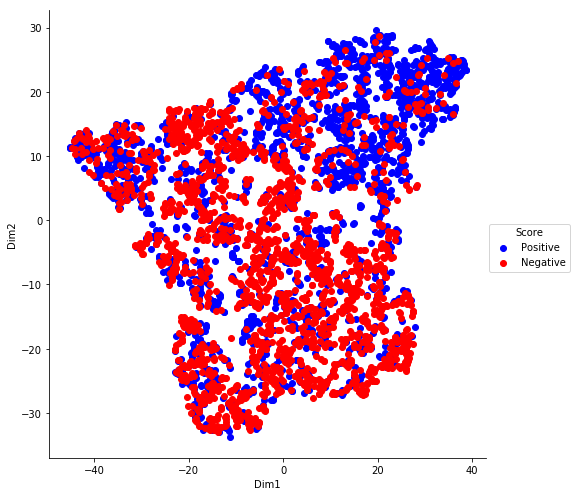

In [68]:
tsne_data_avg_w2v = np.vstack((tsne_data_avg_w2v.T,final_label)).T
tsne_df_avg_w2v = pd.DataFrame(data=tsne_data_avg_w2v,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_avg_w2v,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

### Tf-Idf Word2Vec Representation 

In [69]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [70]:
#print(tfidf_sent_vectors[0])
tfidf_feat[0:15]
#tfidf_feat.index('aachen')
#final_tf_idf[0,2]

['aaaaaahhhhhyaaaaaa',
 'aaaaaahhhhhyaaaaaa fire',
 'aachen',
 'aachen munich',
 'aafco',
 'aafco definit',
 'aafco profil',
 'abandon',
 'abandon need',
 'abandon stuf',
 'abc',
 'abc inform',
 'abc product',
 'abdomen',
 'abdomen becam']

In [147]:
tf_idf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
model = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
#model = TSNE(n_jobs=2)
tsne_data_tf_idf_w2v = model.fit_transform(tf_idf_sent_vectors_arr)

### TSNE Plot of Tf-Idf Word2Vec

##### TSNE Plot with Perplexity 50 and No. of Iterations 5000

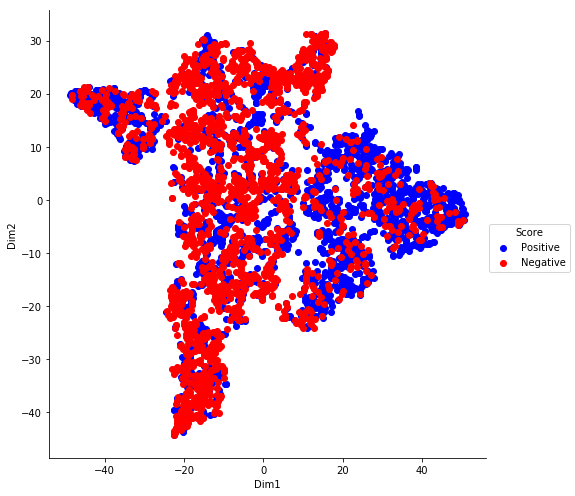

In [148]:
tsne_data_tf_idf_w2v = np.vstack((tsne_data_tf_idf_w2v.T,final_label)).T
tsne_df_tf_idf_w2v = pd.DataFrame(data=tsne_data_tf_idf_w2v,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_tf_idf_w2v,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [71]:
tf_idf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
model = TSNE(n_components=2,random_state=0,perplexity=10,n_iter=1000)
#model = TSNE(n_jobs=2)
tsne_data_tf_idf_w2v = model.fit_transform(tf_idf_sent_vectors_arr)

##### TSNE Plot with Perplexity 10 and No. of Iterations 1000

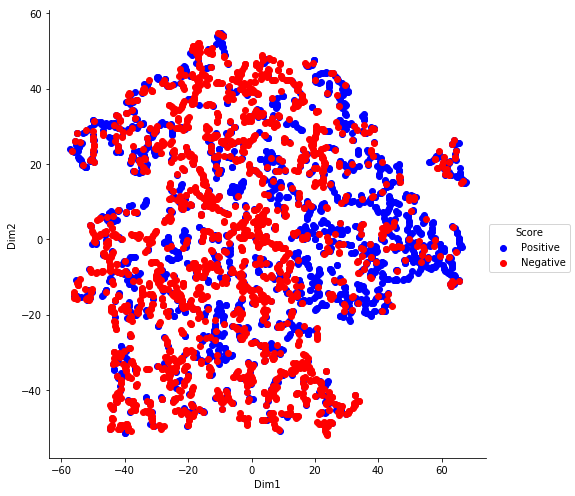

In [72]:
tsne_data_tf_idf_w2v = np.vstack((tsne_data_tf_idf_w2v.T,final_label)).T
tsne_df_tf_idf_w2v = pd.DataFrame(data=tsne_data_tf_idf_w2v,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_tf_idf_w2v,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [73]:
tf_idf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
model = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=2000)
#model = TSNE(n_jobs=2)
tsne_data_tf_idf_w2v = model.fit_transform(tf_idf_sent_vectors_arr)

##### TSNE Plot with Perplexity 30 and No. of Iterations 2000

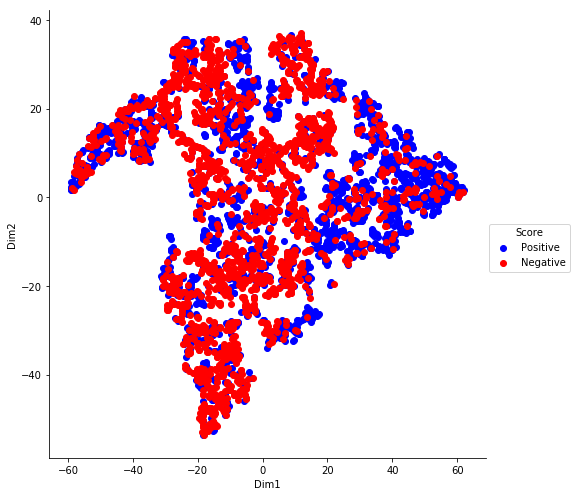

In [74]:
tsne_data_tf_idf_w2v = np.vstack((tsne_data_tf_idf_w2v.T,final_label)).T
tsne_df_tf_idf_w2v = pd.DataFrame(data=tsne_data_tf_idf_w2v,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_tf_idf_w2v,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()

In [75]:
tf_idf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
model = TSNE(n_components=2,random_state=0,perplexity=40,n_iter=1000)
#model = TSNE(n_jobs=2)
tsne_data_tf_idf_w2v = model.fit_transform(tf_idf_sent_vectors_arr)

##### TSNE Plot with Perplexity 40 and No. of Iterations 1000

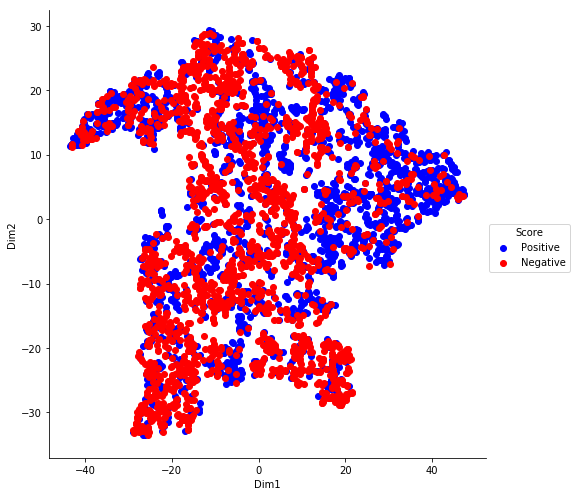

In [76]:
tsne_data_tf_idf_w2v = np.vstack((tsne_data_tf_idf_w2v.T,final_label)).T
tsne_df_tf_idf_w2v = pd.DataFrame(data=tsne_data_tf_idf_w2v,columns=('Dim1','Dim2','Score'))
sns.FacetGrid(tsne_df_tf_idf_w2v,hue='Score',size=7,hue_kws={'color': ['b', 'r']}).map(plt.scatter,'Dim1','Dim2').add_legend()